## Python visualization package (matplotlib)

For this version of the TSP we will work with some geospatial data which gives us the opportunity to visualize our solution. If you have not used matplotlib before you can install the package by uncommenting the code in the cell below.

```python
pip install matplotlib
```
**Note: You must restart the kernel after the package is installed**

In [2]:
#pip install matplotlib

In [3]:
from gurobipy import *
from math import sqrt
import matplotlib.pyplot as plt

# Traveling Salesman Problem


## Reading the data

In the last workshop we learned how to read in a graph from a .txt file. Since the traveling salesman problem is defined over a graph we will repeat this process however the formatting of the document is a bit different. For each instance of the TSP, the first line of the .txt file represents the number of cities $n$. The following $n$ lines of the .txt file will contain the $(x,y)$ coordinates for each of the $n$ cities.

In [4]:
def read(inputfile):
    f = open(inputfile, 'r')
    line = f.readline()
    fields = str.split(line)
    n = int(fields[0])
    
    location = [[] for i in range(n)] # initialize a list of coordinates for each city
    
    
    i = 0
    for line in f:
        fields = line.split('\t')
        loc_x = float(fields[0])
        loc_y = float(fields[1])
        location[i] = (loc_x, loc_y)
        i += 1
    f.close
    
    return location

## Calculating Arc Cost

Since we are only given the coordinates of each city we must compute the distance (or cost) of moving from city $i$ to city $j$. We will simply take the Euclidean distance between these points.

$$c_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$$

Since we are making the simplifying assumption that the costs are symmetric we can reduce our calculations slightly by setting $c_{ji} = c_{ij}$

In [5]:
def calcDistance(location):
    n = len(location) # number of nodes
    distance = [[0 for j in range (n)] for i in range(n)] # initialize arc costs
    for i in range(n):
        for j in range(i,n):
            if i < j:
                x_dist = (location[i][0] - location[j][0])**2
                y_dist = (location[i][1] - location[j][1])**2
                dist = sqrt(x_dist + y_dist)
                distance[i][j] = dist
                distance[j][i] = dist
    
    return distance

## Parameters

In [6]:
inputfile = '../dat/TSP_instance_n_50_s_0.dat'
location = read(inputfile) # location of each city
n = len(location) # number of cities 
distance = calcDistance(location) # arc costs

## Model

We will initialize our model without the subtour elimination constraints.

$$ \begin{align*}
\min \quad &\sum_{(i,j) \in A} c_{ij}x_{ij}\\
\text{s.t}\quad &\sum_{j \in N\setminus\lbrace i \rbrace} x_{ij} = 1 \quad i \in N\\
&\sum_{j \in N\setminus\lbrace i \rbrace} x_{ij} = 1 \quad i \in N\\
& x_{ij} \in \lbrace 0,1 \rbrace \quad (i,j) \in A
\end{align*}$$

In [7]:
TSP = Model('TSP')

x = {}
for i in range(n):
    for j in range(n):
        if i != j:
            x[i,j] = TSP.addVar(vtype=GRB.BINARY, obj = distance[i][j], name = 'x_{}_{}'.format(i,j))
            
TSP.modelSense = GRB.MINIMIZE
TSP.update()

for i in range(n):
    TSP.addConstr(quicksum(x[i,j] for j in range(n) if i != j) == 1, name='leave_{}'.format(i))
    TSP.addConstr(quicksum(x[j,i] for j in range(n) if i != j) == 1, name='enter_{}'.format(i))

Academic license - for non-commercial use only


## Model Parameters

For the TSP we only have one model parameter to set which is ```model.Params.lazyConstraints```. In order to use lazy cuts in our callback we set

```python 
TSP.Params.lazyConstraints = 1
```

In [8]:
TSP.Params.lazyConstraints = 1

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0


## Load Data to TSP Model

Since our callback can only take two arguements, we need load our variables and the number of cities into our TSP model in order to access them during the callback

In [9]:
# Load data into the model
TSP._x = x
TSP._n = n

## Subtour Elmination Callback

Our callback function subtourelim has two arguments: model and where. The model will be the TSP model. We use "where" in order to query the status of the model. The statement

```python
if where == GRB.Callback.MIPSOL
```
indicates that we want to query the model once an **integer solution** is found in the branch and bound tree. Once an integer solution is found we use 

```python
model.cbGetSolution(model._x)
```

to get the current IP solution at this node. With this we can construct a graph represented by the current solution. We will implement a breadth first search (BFS) scheme in order find the number of connected components (subtours) in the current solution. For each subtour $S$, we add the corresponding constraint:

$$ \sum_{i \in S} \sum_{j \in S} x_{ij} \leq |S| - 1$$

to separate these integer solutions.

## Connected Components by BFS

**Input**: An adjacency list for the current IP solution

**Output**: The connected components (subtours) of the current solution
1. $C \gets \emptyset$
2. initialize every vertex as undiscovered
3. for $i \in N$:
4. $\quad K \gets \emptyset$
5. $\quad Q \gets \emptyset$
6. $\quad$ If $i$ is not discovered:
7. $\quad\quad$ label $i$ discovered
8. $\quad\quad$ $K \gets K \cup \lbrace i \rbrace$
9. $\quad\quad$ $Q \gets Q \cup \lbrace i \rbrace$
10. $\quad\quad$ while $Q$ is not empty:
11. $\quad\quad\quad$ $v \gets Q$.dequeue()
12. $\quad\quad\quad$ for $u$ in Adj($v$):
13. $\quad\quad\quad\quad$ if $u$ is not discovered:
14. $\quad\quad\quad\quad\quad$ label $u$ as discovered
15. $\quad\quad\quad\quad\quad$ $K \gets K \cup \lbrace u \rbrace$
16. $\quad\quad\quad\quad\quad$ $Q \gets Q \cup \lbrace u \rbrace$
17. $\quad\quad$ $C \gets C \cup \lbrace K\rbrace$

In [10]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # Retrieve Current Solution
        x_sol = model.cbGetSolution(model._x)
        arcs = tuplelist((i,j) for i,j in model._x.keys() if x_sol[i,j] > 0.5)
        adjList = [[] for i in range(model._n)]
        for i, j in arcs:
            adjList[i].append(j)    
        # Find connected components
        found = [0 for i in range(model._n)]
        components = []
        #------- Separation Algorithm -------
        for i in range(model._n):
            component = []
            queue = []
            if found[i] == 0:
                found[i] = 1
                component.append(i)
                queue.append(i)
                while queue:
                    v = queue.pop(0)
                    for u in adjList[v]:
                        if found[u] == 0:
                            found[u] = 1
                            component.append(u)
                            queue.append(u)
                components.append(component)
        # ------- Check connected components -------
        for component in components:
            if len(component) < model._n:
                print('Add constraint for subtour: {}'.format(component))
                model.cbLazy(quicksum(x[i,j] for i in component for j in component if i !=j) <= len(component) - 1)
            

In [11]:
TSP.optimize(subtourelim)

Optimize a model with 100 rows, 2450 columns and 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Add constraint for subtour: [0, 20, 30, 44, 21, 5, 8, 45, 26, 24]
Add constraint for subtour: [1, 34, 4, 42, 27, 2, 7, 37, 33, 41]
Add constraint for subtour: [3, 38, 36, 35, 32, 25, 31, 43, 16, 47, 17, 10, 46, 22, 11, 40, 12, 9, 14, 13, 29, 19, 23]
Add constraint for subtour: [6, 18, 48, 28, 49, 15, 39]
Presolve time: 0.02s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)
Add constraint for subtour: [0, 1]
Add constraint for subtour: [2, 14]
Add constraint for subtour: [3, 7]
Add constraint for subtour: [4, 29, 32]
Add constraint for subtour: [5, 48]
Add constraint for subtour: [6, 16]
Add constraint for subtour: [8, 36]
Add constraint for subtour: [9, 1

## Visualization

We can utilize the python package matplotlib to visualize our solution.

In [16]:
def plotSolution(x_sol, location):
    coord_x = [v[0] for v in location]
    coord_y = [v[1] for v in location]
    Arcs = []
    plt.clf()
    for i, j in x_sol.keys():
        if x_sol[i, j].X > 0.5:
            plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], color='b', alpha=0.4,zorder=0)
    plt.scatter(x=coord_x, y=coord_y, color='r', zorder=1)
    for i in range(len(location)):
        plt.annotate(i, (coord_x[i]+0.25,coord_y[i]+0.25))
    plt.xlim((0,22))
    plt.ylim((0,22))
    #plt.savefig('TSP.jpg')
    plt.show()

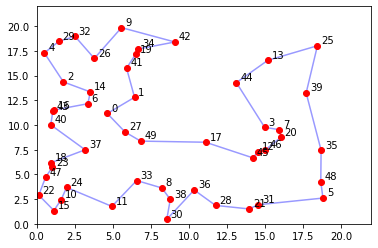

In [17]:
plotSolution(x, location)